In [168]:
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
 
#import lightgbm as lgb
import catboost as catb

import seaborn as sns
import matplotlib.pyplot as plt

In [169]:
df = pd.read_pickle('features.df')

In [170]:
df.head()

,Maximum Open Credit,Current Loan Amount,Number of Open Accounts,Monthly Debt,Annual Income,Credit Score,Years in current job,Home Ownership,Term,Years of Credit History,Purpose_0,Purpose_1,Purpose_2,tax_problems_0,tax_problems_1,tax_problems_2,Current Loan Max,Credit Score Max,Credit Default
0,83.234273,440.395443,3.203605,114.227836,11.966375,3.313631e+52,0,0,0,1,1,0,0,0,1,0,1,0,0
1,94.416025,412.539881,3.685878,166.219138,12.592533,2.450431e+52,1,0,1,1,1,0,0,0,1,0,0,0,1
2,94.429018,440.395443,3.203605,145.657216,12.335357,2.780408e+52,1,1,0,0,1,0,0,0,1,0,1,0,0
3,57.999051,298.500521,2.747838,134.101602,12.392494,7.969733e+51,1,0,0,0,1,0,0,0,1,0,0,0,0
4,72.777459,302.987637,3.458633,109.364570,12.362319,1.543828e+52,1,0,0,1,1,0,0,0,1,0,0,0,0


In [171]:
df.columns

Index(['Maximum Open Credit', 'Current Loan Amount', 'Number of Open Accounts',
       'Monthly Debt', 'Annual Income', 'Credit Score', 'Years in current job',
       'Home Ownership', 'Term', 'Years of Credit History', 'Purpose_0',
       'Purpose_1', 'Purpose_2', 'tax_problems_0', 'tax_problems_1',
       'tax_problems_2', 'Current Loan Max', 'Credit Score Max',
       'Credit Default'],
      dtype='object')

In [172]:
#df = df.drop('tax_problems', axis=1)
df.describe()

,Maximum Open Credit,Current Loan Amount,Number of Open Accounts,Monthly Debt,Annual Income,Credit Score,Years in current job,Home Ownership,Term,Years of Credit History,Purpose_0,Purpose_1,Purpose_2,tax_problems_0,tax_problems_1,tax_problems_2,Current Loan Max,Credit Score Max,Credit Default
count,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7.139000e+03,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000,7139.000000
mean,76.169670,420.200365,3.099173,155.317899,12.701748,1.889910e+52,0.950693,0.476537,0.258299,0.679367,0.977168,0.018910,0.003922,0.006724,0.979829,0.013447,0.114722,0.053789,0.284914
std,12.898221,101.280797,0.626737,43.572186,0.390135,8.257215e+51,0.216523,0.499484,0.437730,0.466753,0.149379,0.136218,0.062508,0.081727,0.140594,0.115188,0.318708,0.225617,0.451405
min,24.203851,145.059887,1.226202,9.576656,11.063509,3.275465e+50,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,67.325454,350.811560,2.747838,126.784729,12.454089,1.285917e+52,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,76.039566,435.759116,3.063028,155.310890,12.696063,1.993705e+52,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,84.983117,483.864003,3.458633,184.245408,12.950478,2.513306e+52,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,110.311751,647.858465,4.966237,287.023393,14.454391,3.482921e+52,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [173]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print(f'TRAIN\n\n{classification_report(y_train_true, y_train_pred)}')
    print(f'TEST\n\n{classification_report(y_test_true, y_test_pred)}')
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [174]:
def balance_df_by_target(df, target_name):
    target_counts = df[target_name].value_counts()
    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    for i in range(disbalance_coeff):
        sample = df.loc[df[target_name]==minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)
    return df.sample(frac=1)

In [175]:
TARGET_NAME = 'Credit Default'
NUM_FEATURES = ['Maximum Open Credit', 'Current Loan Amount', 'Annual Income', 'Number of Open Accounts',
                'Monthly Debt', 'Credit Score']
FEATURE_NAMES = df.columns.drop(TARGET_NAME)
FEATURE_NAMES = ['Maximum Open Credit', 'Current Loan Amount', 'Number of Open Accounts',
       'Monthly Debt', 'Annual Income', 'Credit Score', 'Years in current job',
       'Home Ownership', 'Term', 'Years of Credit History',
       'Purpose_1', 'Purpose_2', 'tax_problems_0', 'Current Loan Max', 'Credit Score Max']

In [176]:
X = df[FEATURE_NAMES]
y = df[TARGET_NAME]

In [239]:
CAT_FEATURES = set(FEATURE_NAMES).difference(NUM_FEATURES)
CAT_FEATURES

{'Credit Score Max',
 'Current Loan Max',
 'Home Ownership',
 'Purpose_1',
 'Purpose_2',
 'Term',
 'Years in current job',
 'Years of Credit History',
 'tax_problems_0'}

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=.25, random_state=42)

In [178]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balancing = balance_df_by_target(df_for_balancing, TARGET_NAME)
df_balancing[TARGET_NAME].value_counts()

0    3840
1    3028
Name: Credit Default, dtype: int64

In [179]:
X_train = df_balancing.drop(columns=TARGET_NAME)
y_train = df_balancing[TARGET_NAME]

In [180]:
scaler = StandardScaler()
X_train[NUM_FEATURES] = scaler.fit_transform(X_train[NUM_FEATURES])
X_train.head()

,Maximum Open Credit,Current Loan Amount,Number of Open Accounts,Monthly Debt,Annual Income,Credit Score,Years in current job,Home Ownership,Term,Years of Credit History,Purpose_1,Purpose_2,tax_problems_0,Current Loan Max,Credit Score Max
123,-0.337817,0.138560,0.922482,0.283937,0.291795,0.987569,1,1,0,1,0,0,0,0,0
1492,1.638077,0.183205,0.364703,0.376917,0.860189,1.517700,1,1,0,0,0,0,0,1,0
203,0.162527,0.183205,0.922482,-0.944126,0.139142,-1.051847,1,0,1,1,0,0,0,1,0
1807,-0.900653,-1.024354,0.155689,0.103275,0.662671,0.906356,1,1,0,1,0,0,0,0,0
3904,-0.742943,0.206531,-1.169337,-0.784951,-0.566329,-1.772999,1,0,1,0,0,0,0,0,0


In [181]:
with open('model_scaler', 'wb') as f:
    pickle.dump(scaler, f)

In [182]:
X_test[NUM_FEATURES] = scaler.transform(X_test[NUM_FEATURES])
X_test.head()

<ipython-input-182-71d7a53df9bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[NUM_FEATURES] = scaler.transform(X_test[NUM_FEATURES])
/Users/kosmosivanov/git-repo/Python_DS_more/virt_env/lib/python3.8/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Maximum Open Credit,Current Loan Amount,Number of Open Accounts,Monthly Debt,Annual Income,Credit Score,Years in current job,Home Ownership,Term,Years of Credit History,Purpose_1,Purpose_2,tax_problems_0,Current Loan Max,Credit Score Max
3187,-0.589278,-1.115650,-1.169337,-0.484078,-0.062128,0.193066,0,0,0,0,0,0,0,0,0
5541,-0.502879,-0.684357,-0.067823,-1.177943,-0.987655,-0.725191,1,0,1,1,0,0,0,0,0
6092,-1.077555,0.335575,-1.169337,-0.670807,0.125351,-1.119086,1,1,1,1,0,0,0,0,0
744,1.478731,1.706202,0.746669,1.026965,1.154857,-1.021759,1,1,1,0,0,0,0,0,0
1503,1.984107,1.314296,0.746669,0.391678,-0.163368,0.389300,1,0,1,1,0,0,0,0,0


In [183]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred.round(), y_test, y_test_pred.round())

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.83      0.75      3840
           1       0.70      0.51      0.59      3028

    accuracy                           0.69      6868
   macro avg       0.69      0.67      0.67      6868
weighted avg       0.69      0.69      0.68      6868

TEST

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1265
           1       0.57      0.57      0.57       520

    accuracy                           0.75      1785
   macro avg       0.69      0.69      0.69      1785
weighted avg       0.75      0.75      0.75      1785

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1041  224
1                226  294


In [184]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred.round(), y_test, y_test_pred.round())

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      3840
           1       0.79      0.73      0.76      3028

    accuracy                           0.79      6868
   macro avg       0.79      0.79      0.79      6868
weighted avg       0.79      0.79      0.79      6868

TEST

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1265
           1       0.48      0.51      0.49       520

    accuracy                           0.69      1785
   macro avg       0.63      0.64      0.64      1785
weighted avg       0.70      0.69      0.70      1785

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               973  292
1               254  266


In [185]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=42)
model_catb.fit(X_train, y_train)
y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred.round(), y_test, y_test_pred.round())

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      3840
           1       0.91      0.81      0.86      3028

    accuracy                           0.88      6868
   macro avg       0.89      0.88      0.88      6868
weighted avg       0.89      0.88      0.88      6868

TEST

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1265
           1       0.56      0.50      0.53       520

    accuracy                           0.74      1785
   macro avg       0.68      0.67      0.67      1785
weighted avg       0.73      0.74      0.73      1785

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1057  208
1                259  261


In [246]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=42)

In [247]:
cv = KFold(n_splits=3, random_state=42, shuffle=True)

In [248]:
params = {
    'iterations': [50, 100, 200, 500],
    'max_depth': [3, 5, 7, 8],
    'learning_rate': [0.001, 0.01, 0.05, 1]
}

In [249]:
rs = GridSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x12c838eb0>,
             iid='deprecated', n_jobs=-1,
             param_grid={'iterations': [50, 100, 200, 500],
                         'learning_rate': [0.001, 0.01, 0.05, 1],
                         'max_depth': [3, 5, 7, 8]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [250]:
rs.best_score_

0.7968325538198938

In [251]:
rs.best_params_

{'iterations': 500, 'learning_rate': 1, 'max_depth': 8}

In [192]:
final_model = catb.CatBoostClassifier(n_estimators=200, max_depth=5, 
                                      learning_rate=0.05, silent=True, random_state=42)

In [193]:
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred.round(), y_test, y_test_pred.round())

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.86      0.80      3840
           1       0.78      0.62      0.69      3028

    accuracy                           0.76      6868
   macro avg       0.76      0.74      0.75      6868
weighted avg       0.76      0.76      0.75      6868

TEST

              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1265
           1       0.54      0.56      0.55       520

    accuracy                           0.74      1785
   macro avg       0.68      0.68      0.68      1785
weighted avg       0.74      0.74      0.74      1785

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1022  243
1                229  291


In [244]:
final_model = catb.CatBoostClassifier(iterations=250, custom_loss=['AUC', 'Accuracy'], 
                                      learning_rate=0.05, silent=True, random_state=42)

In [ ]:
final_model.fit(X_train, y_train, cat_features=CAT_FEATURES,
                eval_set=(X_test, y_test),
                plot=True)

In [ ]:
final_model.fit(X_train, y_train)
print(final_model.get_params())
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred.round(), y_test, y_test_pred.round())

In [ ]:
with open('model_class.bin', 'wb') as f:
    pickle.dump(final_model, f)

In [ ]:
plt.figure(figsize=(25, 5))
plt.plot(y_test_pred_probs[:20, 1], 'r', label='predict_proba 1')
#plt.plot(y_test_pred_probs[:10, 0], 'g', label='predict_proba 0')
plt.plot(y_test_pred[:20], '--b', label='predict_classif')
plt.plot(y_test.iloc[:20].values, 'ok', label='true y')

y_p = np.array(y_test_pred_probs[:,1]>0.52).astype('int')
plt.plot(y_p[:20], '--k', label='predict classif with porog')
plt.legend()
plt.show()

In [ ]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [ ]:
show_learning_curve_plot(final_model, X, y)

In [ ]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.48, 0.52, 30):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [ ]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [ ]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [ ]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [221]:
final_model.fit(X_train, y_train)
print(final_model.get_params())
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred.round(), y_test, y_test_pred.round())

{'learning_rate': 0.05, 'l2_leaf_reg': 3, 'silent': True, 'max_depth': 5, 'n_estimators': 200, 'random_state': 42}
TRAIN

              precision    recall  f1-score   support

           0       0.74      0.86      0.80      3840
           1       0.78      0.62      0.69      3028

    accuracy                           0.76      6868
   macro avg       0.76      0.74      0.75      6868
weighted avg       0.76      0.76      0.75      6868

TEST

              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1265
           1       0.54      0.56      0.55       520

    accuracy                           0.74      1785
   macro avg       0.68      0.68      0.68      1785
weighted avg       0.74      0.74      0.74      1785

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1022  243
1                229  291


In [200]:
with open('model_class.bin', 'wb') as f:
    pickle.dump(final_model, f)

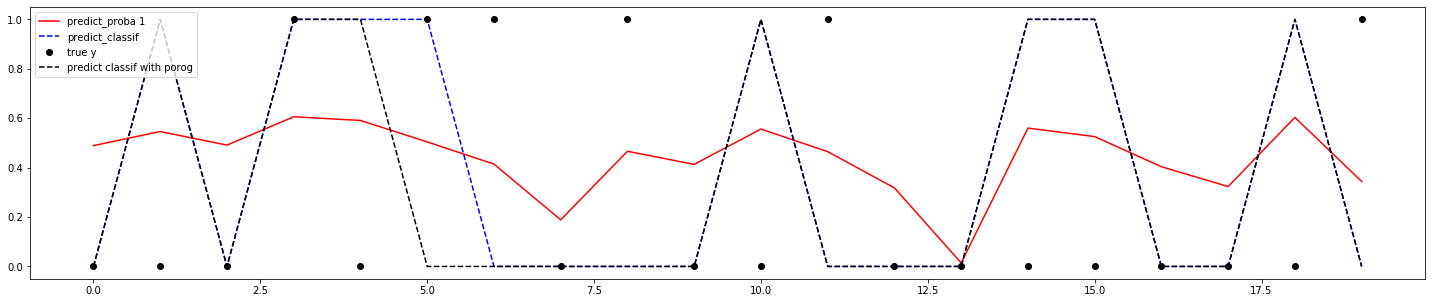

In [210]:
plt.figure(figsize=(25, 5))
plt.plot(y_test_pred_probs[:20, 1], 'r', label='predict_proba 1')
#plt.plot(y_test_pred_probs[:10, 0], 'g', label='predict_proba 0')
plt.plot(y_test_pred[:20], '--b', label='predict_classif')
plt.plot(y_test.iloc[:20].values, 'ok', label='true y')

y_p = np.array(y_test_pred_probs[:,1]>0.52).astype('int')
plt.plot(y_p[:20], '--k', label='predict classif with porog')
plt.legend()
plt.show()

In [202]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

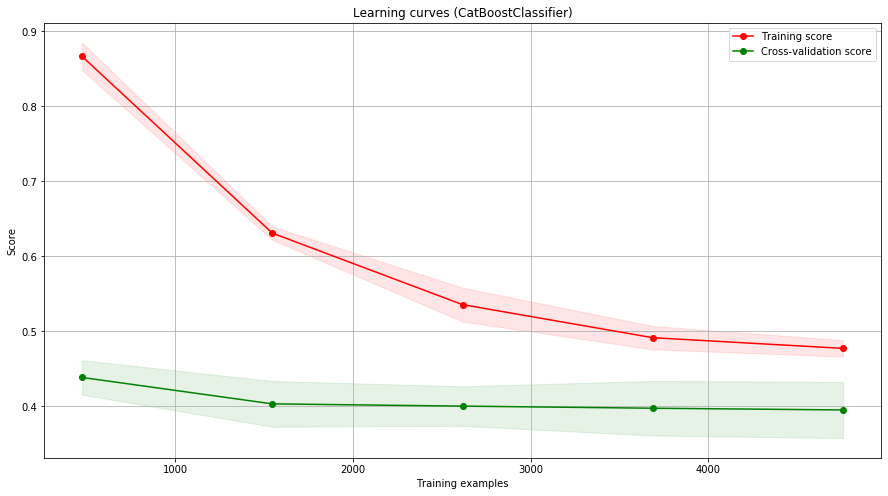

In [203]:
show_learning_curve_plot(final_model, X, y)

In [204]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.48, 0.52, 30):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

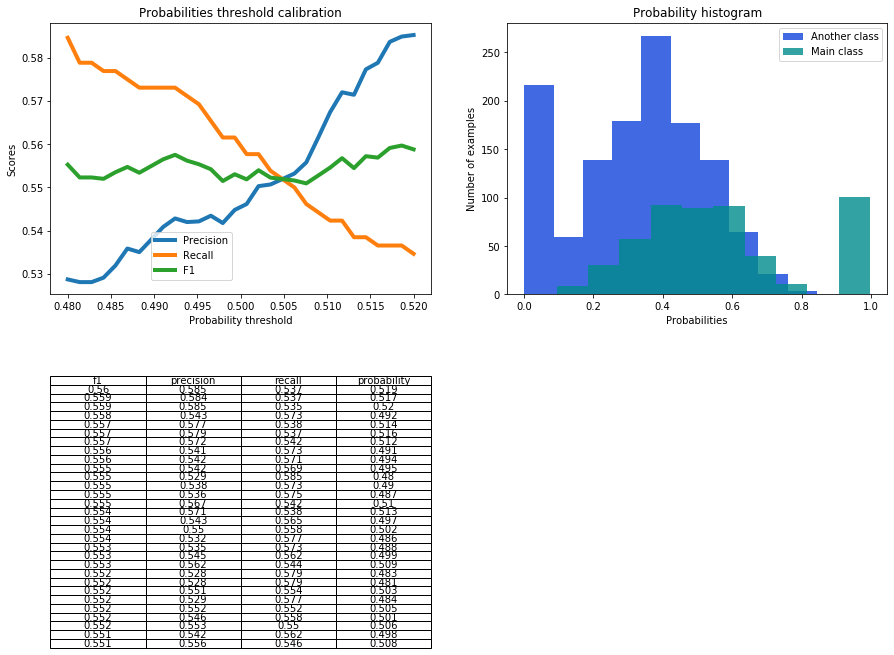

In [205]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [165]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

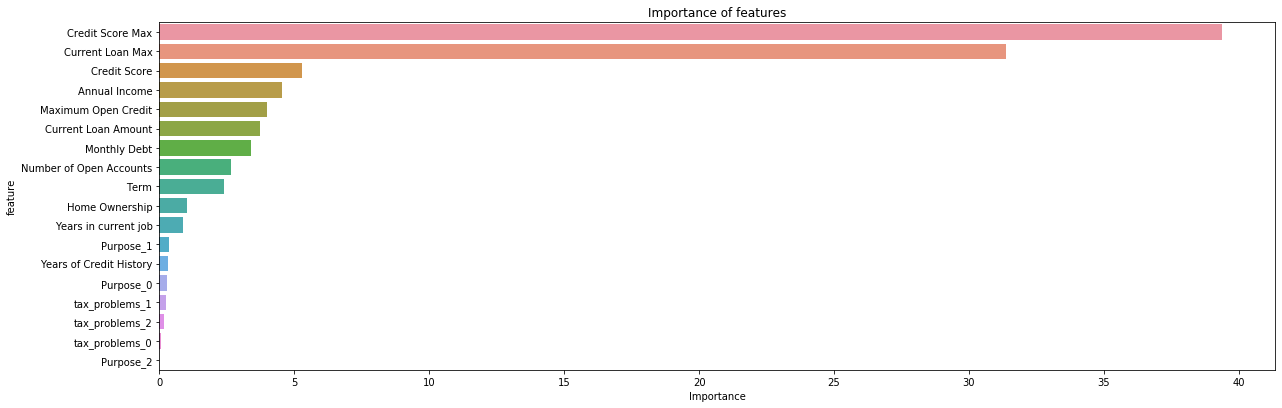

In [166]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

['Maximum Open Credit',
 'Current Loan Amount',
 'Number of Open Accounts',
 'Monthly Debt',
 'Annual Income',
 'Credit Score',
 'Years in current job',
 'Home Ownership',
 'Term',
 'Years of Credit History',
 'Purpose_1',
 'Purpose_2',
 'tax_problems_0',
 'Current Loan Max',
 'Credit Score Max']